# Image classification

This note book is based on the Tensorflow tutorial <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification">Image classification</a>.

## Import TensorFlow and other libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import and explore the dataset

For the moment we use the ```sample_dataset```, which contains about 700 photos of cheeses. The dataset one sub-directory for each class:

```
sample_dataset/
  Camembert de Normandie/
  Cantal/
  etc.
```

In [8]:
import pathlib
print(pathlib.Path.cwd())
data_dir = pathlib.Path('data/sample_dataset')
print(data_dir)

/home/brice/Dropbox/Info/Code/Data science and ML/Cheezam
data/sample_dataset


Let us count the number of jpg images:

In [20]:
image_count_jpg = len(list(data_dir.glob('*/*.jpg')))
image_count_jpeg = len(list(data_dir.glob('*/*.jpeg')))
image_count = image_count_jpg + image_count_jpeg
print(image_count_jpg, image_count_jpeg, image_count)

602 69 671


Here is a picture of a Cantal:

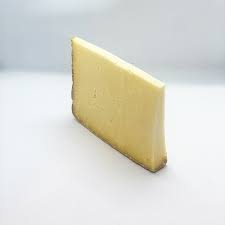

In [14]:
cantal_paths = list(data_dir.glob('Cantal/*'))
PIL.Image.open(str(cantal_paths[0]))

And a Roquefort:

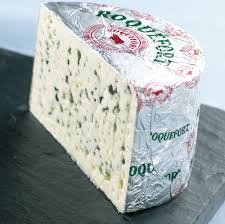

In [15]:
roquefort_paths = list(data_dir.glob('Roquefort/*'))
PIL.Image.open(str(roquefort_paths[0]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 256
img_width = 256

Let's use 80% of the images for training, and 20% for validation.

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 721 files belonging to 6 classes.
Using 577 files for training.


2021-11-02 23:05:22.312640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-02 23:05:22.312675: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 23:05:22.312697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brice-XPS15): /proc/driver/nvidia/version does not exist
2021-11-02 23:05:22.313385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 721 files belonging to 6 classes.
Using 144 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [23]:
class_names = train_ds.class_names
print(class_names)

['Camembert de Normandie', 'Cantal', 'Emmenthal de Savoie', "Fourme d'Ambert", 'Fourme de Montbrison', 'Roquefort']


## Visualize the data

Here are the first nine images from the training dataset:

2021-11-02 23:06:10.121489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-02 23:06:10.784893: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 42378027 exceeds 10% of free system memory.
2021-11-02 23:06:11.126893: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36158976 exceeds 10% of free system memory.
2021-11-02 23:06:11.166577: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66355200 exceeds 10% of free system memory.
2021-11-02 23:06:11.647985: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36000000 exceeds 10% of free system memory.
2021-11-02 23:06:12.257741: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43863192 exceeds 10% of free system memory.
2021-11-02 23:06:13.382506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


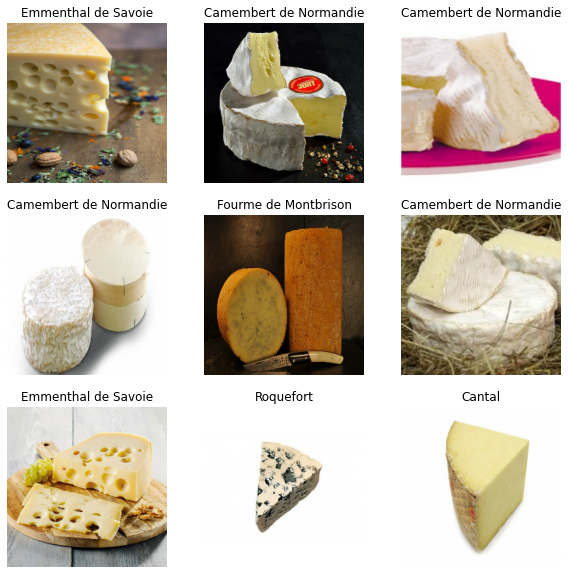

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2021-11-02 23:07:24.523639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


(32, 256, 256, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 256, 256, 3)`. This is a batch of 32 images of shape `256x256x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [27]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

2021-11-02 23:09:54.069140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


0.034768797 0.9108491


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [30]:
num_classes = len(class_names)
print(num_classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

6


## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

## Train the model

In [33]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
19/19 [==============================] - 31s 2s/step - loss: 2.0743 - accuracy: 0.3102 - val_loss: 1.5435 - val_accuracy: 0.3958
Epoch 2/10
19/19 [==============================] - 20s 1s/step - loss: 1.3980 - accuracy: 0.4333 - val_loss: 1.2766 - val_accuracy: 0.5139
Epoch 3/10
19/19 [==============================] - 13s 693ms/step - loss: 1.1000 - accuracy: 0.5893 - val_loss: 1.2111 - val_accuracy: 0.5417
Epoch 4/10
19/19 [==============================] - 23s 1s/step - loss: 0.8173 - accuracy: 0.7002 - val_loss: 1.3725 - val_accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 25s 1s/step - loss: 0.5921 - accuracy: 0.7868 - val_loss: 1.3626 - val_accuracy: 0.5694
Epoch 6/10
19/19 [==============================] - 25s 1s/step - loss: 0.4112 - accuracy: 0.8804 - val_loss: 1.7981 - val_accuracy: 0.4792
Epoch 7/10
19/19 [==============================] - 24s 1s/step - loss: 0.2854 - accuracy: 0.9029 - val_loss: 1.6602 - val_accuracy: 0.5486
Epoch 8/10
19/19 

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

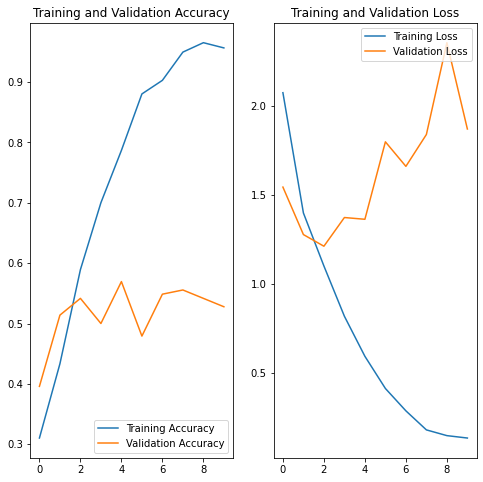

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 50% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

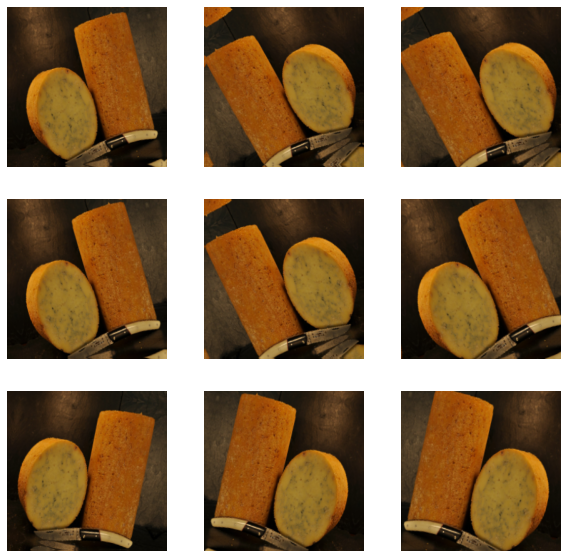

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [37]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)       

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
19/19 [==============================] - 19s 895ms/step - loss: 2.0150 - accuracy: 0.2669 - val_loss: 1.6171 - val_accuracy: 0.2847
Epoch 2/15
19/19 [==============================] - 13s 683ms/step - loss: 1.4398 - accuracy: 0.4073 - val_loss: 1.3267 - val_accuracy: 0.4722
Epoch 3/15
19/19 [==============================] - 13s 681ms/step - loss: 1.2687 - accuracy: 0.4870 - val_loss: 1.4933 - val_accuracy: 0.4722
Epoch 4/15
19/19 [==============================] - 23s 1s/step - loss: 1.3382 - accuracy: 0.4731 - val_loss: 1.4203 - val_accuracy: 0.4583
Epoch 5/15
19/19 [==============================] - 28s 1s/step - loss: 1.2288 - accuracy: 0.5199 - val_loss: 1.3656 - val_accuracy: 0.4722
Epoch 6/15
19/19 [==============================] - 29s 2s/step - loss: 1.1497 - accuracy: 0.5771 - val_loss: 1.1927 - val_accuracy: 0.6042
Epoch 7/15
19/19 [==============================] - 28s 1s/step - loss: 1.1079 - accuracy: 0.5841 - val_loss: 1.2757 - val_accuracy: 0.4583
Epoch 8/15


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

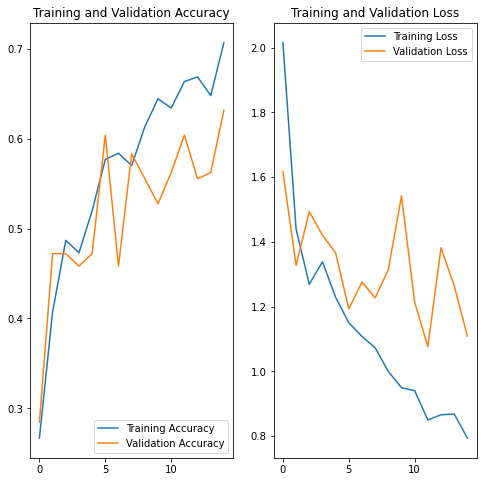

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [80]:
from IPython.display import display

def cheezam(filename : str):
    filepath = 'data/test/'+filename
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display(PIL.Image.open(filepath))

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

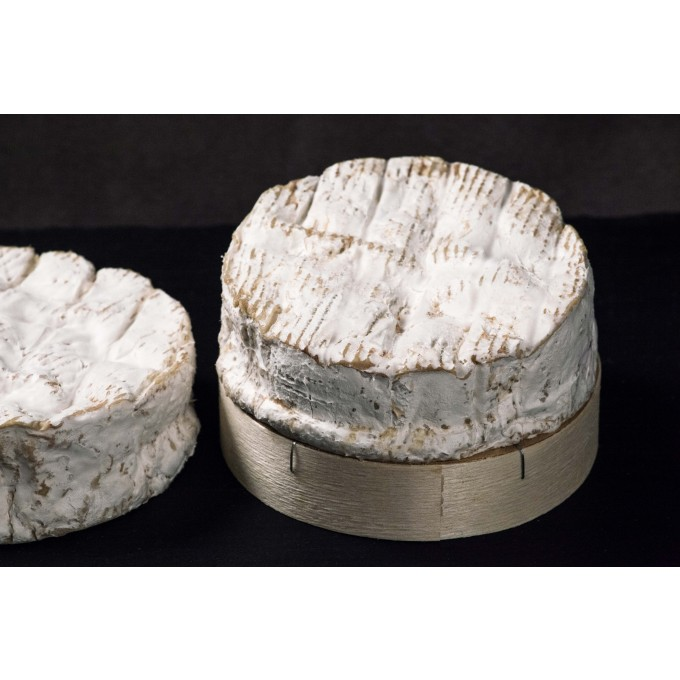

This cheese is most likely a Camembert de Normandie with a 52.30 percent confidence.


In [87]:
cheezam('test9.jpg')